In [46]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math
import os
import uproot
import json
import math
import gc

In [47]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open('../event_totals.json', 'r') as f:
    totals = json.load(f)

In [48]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [49]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [50]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [51]:
totals['ww'] = totals['diboson_ww']
totals['wz'] = totals['diboson_wz']
totals['zz'] = totals['diboson_zz']

In [52]:
columns=['goodjets.msoftdrop', 'goodjets.pt', ("ungroomed_ecfs", "6e5^1.0")]

In [53]:
def read_files(input_path):
    if ('.parquet' in os.listdir(input_path)[0]):
        output = ak.from_parquet(f'{input_path}/*', columns=columns)
    else:
        output = {}
        for i in os.listdir(input_path):
            if ('flat400' not in i):
                output[i] = ak.from_parquet(f'{input_path}/{i}/*', columns=columns)
            else:
                continue
    return output

In [54]:
region = 'nolepton'
path = '/project01/ndcms/cmoore24/skims/full_skims'

In [55]:
mc = read_files(f'{path}/{region}/mc')

In [56]:
mc['ww'] = mc['diboson_ww']
mc['wz'] = mc['diboson_wz']
mc['zz'] = mc['diboson_zz']
del(mc['diboson_ww'])
del(mc['diboson_wz'])
del(mc['diboson_zz'])

In [57]:
for i in mc:
    if type(mc[i]) == dict:
        for j in mc[i]:
            for k in mc[i][j].fields:
                if 'event' in k:
                    continue
                else:
                    try:
                        mc[i][j][k] = ak.firsts(mc[i][j][k])
                    except:
                        continue
    else:
        for j in mc[i].fields:
            if 'event' in j:
                continue
            else:
                try:
                    mc[i][j] = ak.firsts(mc[i][j])
                except:
                    continue

In [58]:
data = read_files(f'{path}/{region}/data')

In [59]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            for k in data[i][j].fields:
                if 'event' in k:
                    continue
                else:
                    try:
                        data[i][j][k] = ak.firsts(data[i][j][k])
                    except:
                        continue
    else:
        for j in data[i].fields:
            if 'event' in j:
                continue
            else:
                try:
                    data[i][j] = ak.firsts(data[i][j])
                except:
                    continue

In [60]:
upper = 1200
lower = 500

In [61]:
for i in xsecs:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mask = ((mc[i][j].goodjets.pt >= lower) & (mc[i][j].goodjets.pt <= upper))
            mc[i][j] = mc[i][j][mask]
    else:
        mask = ((mc[i].goodjets.pt >= lower) & (mc[i].goodjets.pt <= upper))
        mc[i] = mc[i][mask]

In [62]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            mask = ((data[i][j].goodjets.pt >= lower) & (data[i][j].goodjets.pt <= upper))
            data[i][j] = data[i][j][mask]
    else:
        mask = ((data[i].goodjets.pt >= lower) & (data[i].goodjets.pt <= upper))
        data[i] = data[i][mask]

In [63]:
data_s = {}
for i in data:
    if "Jet" in i:
        data_s[i] = data[i]

In [64]:
data_arr = ak.concatenate([data[i] for i in data_s])

In [65]:
var = '6e5^1.0'

In [66]:
ecf_max = 1e-8#ak.max(data_arr.ungroomed_ecfs[var])
ecf_min = ak.min(data_arr.ungroomed_ecfs[var])

In [67]:
data_hist = hist.Hist.new.Reg(40, ecf_min, ecf_max, name='ECF', label='Data ECF').Weight()
data_hist.fill(ECF=data_arr.ungroomed_ecfs[var]);

In [68]:
def ecf_hist(dataset, call):
    make_hist = hist.Hist.new.Reg(40, ecf_min, ecf_max, name='ECF', label='MC ECF').Weight()
    make_hist.fill(ECF=dataset.ungroomed_ecfs[var])
    return make_hist

In [69]:
mc2 = {}
for i in xsecs:
    if type(mc[i]) == dict:
        for j in mc[i]:
            mc2[j] = mc[i][j]
    else:
        mc2[i] = mc[i]
mc = mc2

In [70]:
hists = {}
for i in mc:
    if type(mc[i]) == dict:
        hists[i] = {}
        for j in mc[i]:
            hists[i][j] = msd_hist(mc[i][j])
    else:
        hists[i] = ecf_hist(mc[i], j)

In [71]:
IL = 44.99

In [72]:
scaleHgg = ((IL*(xsecs['hgg']*1000)*0.0817)/(totals['hgg']))
hists['hgg'].view(flow=True)[:] *= scaleHgg

scaleHbb = ((IL*(xsecs['hbb']*1000)*0.581)/(totals['hbb']))
hists['hbb'].view(flow=True)[:] *= scaleHbb

In [73]:
for i in mc:
    if (i == 'hgg') or (i == 'hbb'):
        continue
    else:
        scale = ((IL*(xsecs[i]*1000))/(totals[i]))
        hists[i].view(flow=True)[:] *= scale

In [74]:
mc_hist = sum(hists[i] for i in hists)

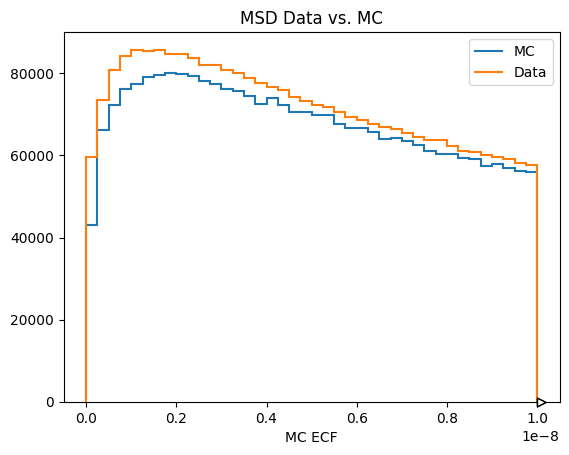

In [75]:
mc_hist.plot1d(label='MC', density=False, yerr=False)
data_hist.plot1d(label='Data', density=False, yerr=False)
plt.legend()
plt.title('MSD Data vs. MC')
plt.show()

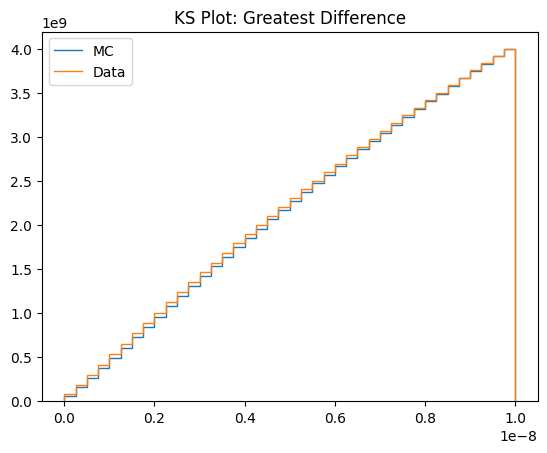

In [76]:
fig, ax = plt.subplots()

ax.stairs(np.cumsum(mc_hist.density()), edges=mc_hist.axes[0].edges, label='MC');
ax.stairs(np.cumsum(data_hist.density()), edges=data_hist.axes[0].edges, label='Data');
plt.legend()
plt.title('KS Plot: Greatest Difference')
plt.show()

In [77]:
mc_values, mc_bins = mc_hist.to_numpy()
data_values, data_bins = data_hist.to_numpy()
mc_density = mc_values / mc_values.sum()
data_density = data_values / data_values.sum()
mc_cdf = np.cumsum(mc_density)
data_cdf = np.cumsum(data_density)
ks_statistic = np.max(np.abs(mc_cdf - data_cdf))
print(f"KS Statistic: {ks_statistic}")
print(f"Adjusted: {-math.log10(ks_statistic)}")

KS Statistic: 0.011380571041197385
Adjusted: 1.9438359458654706
